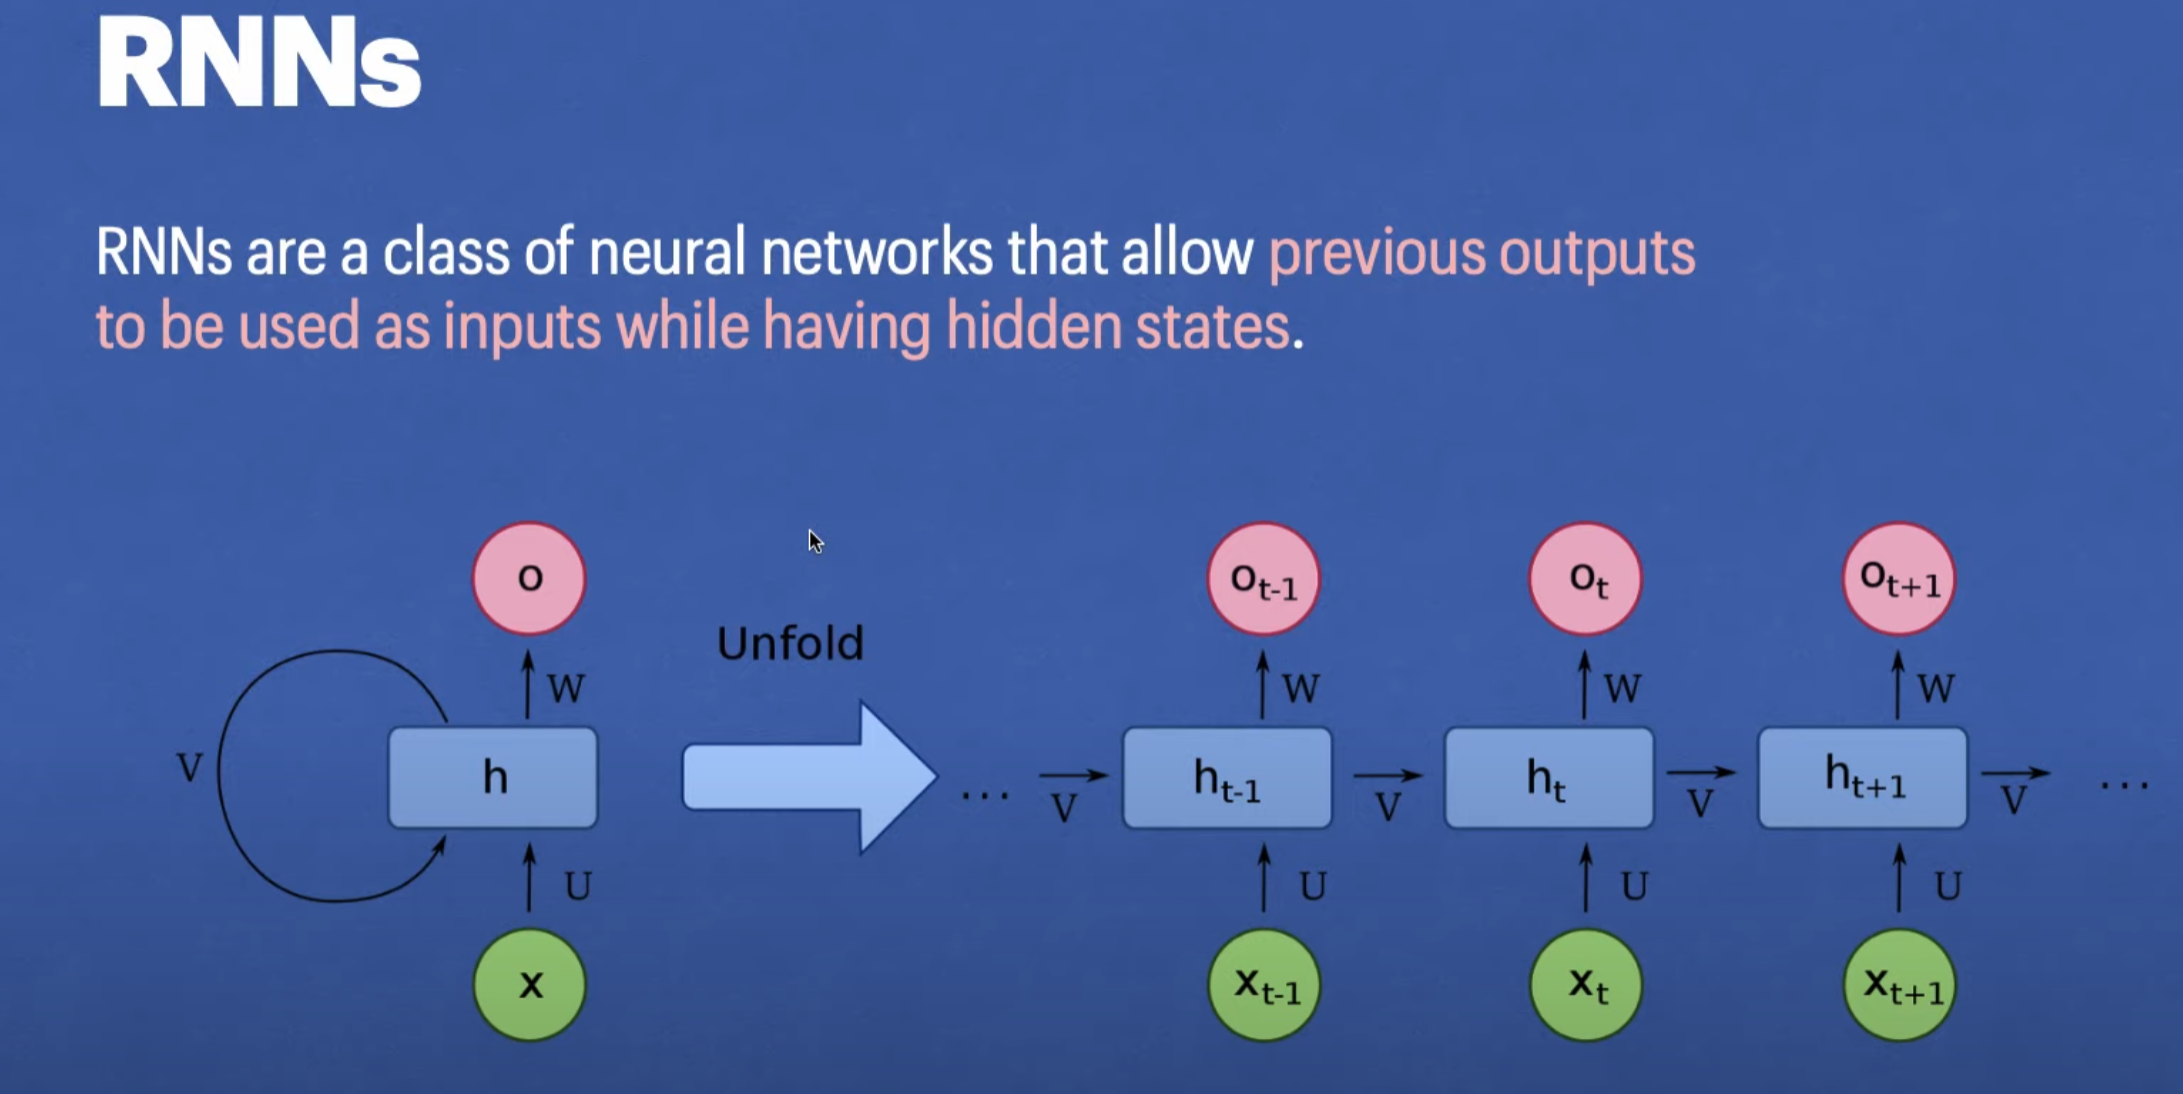

We use many to many


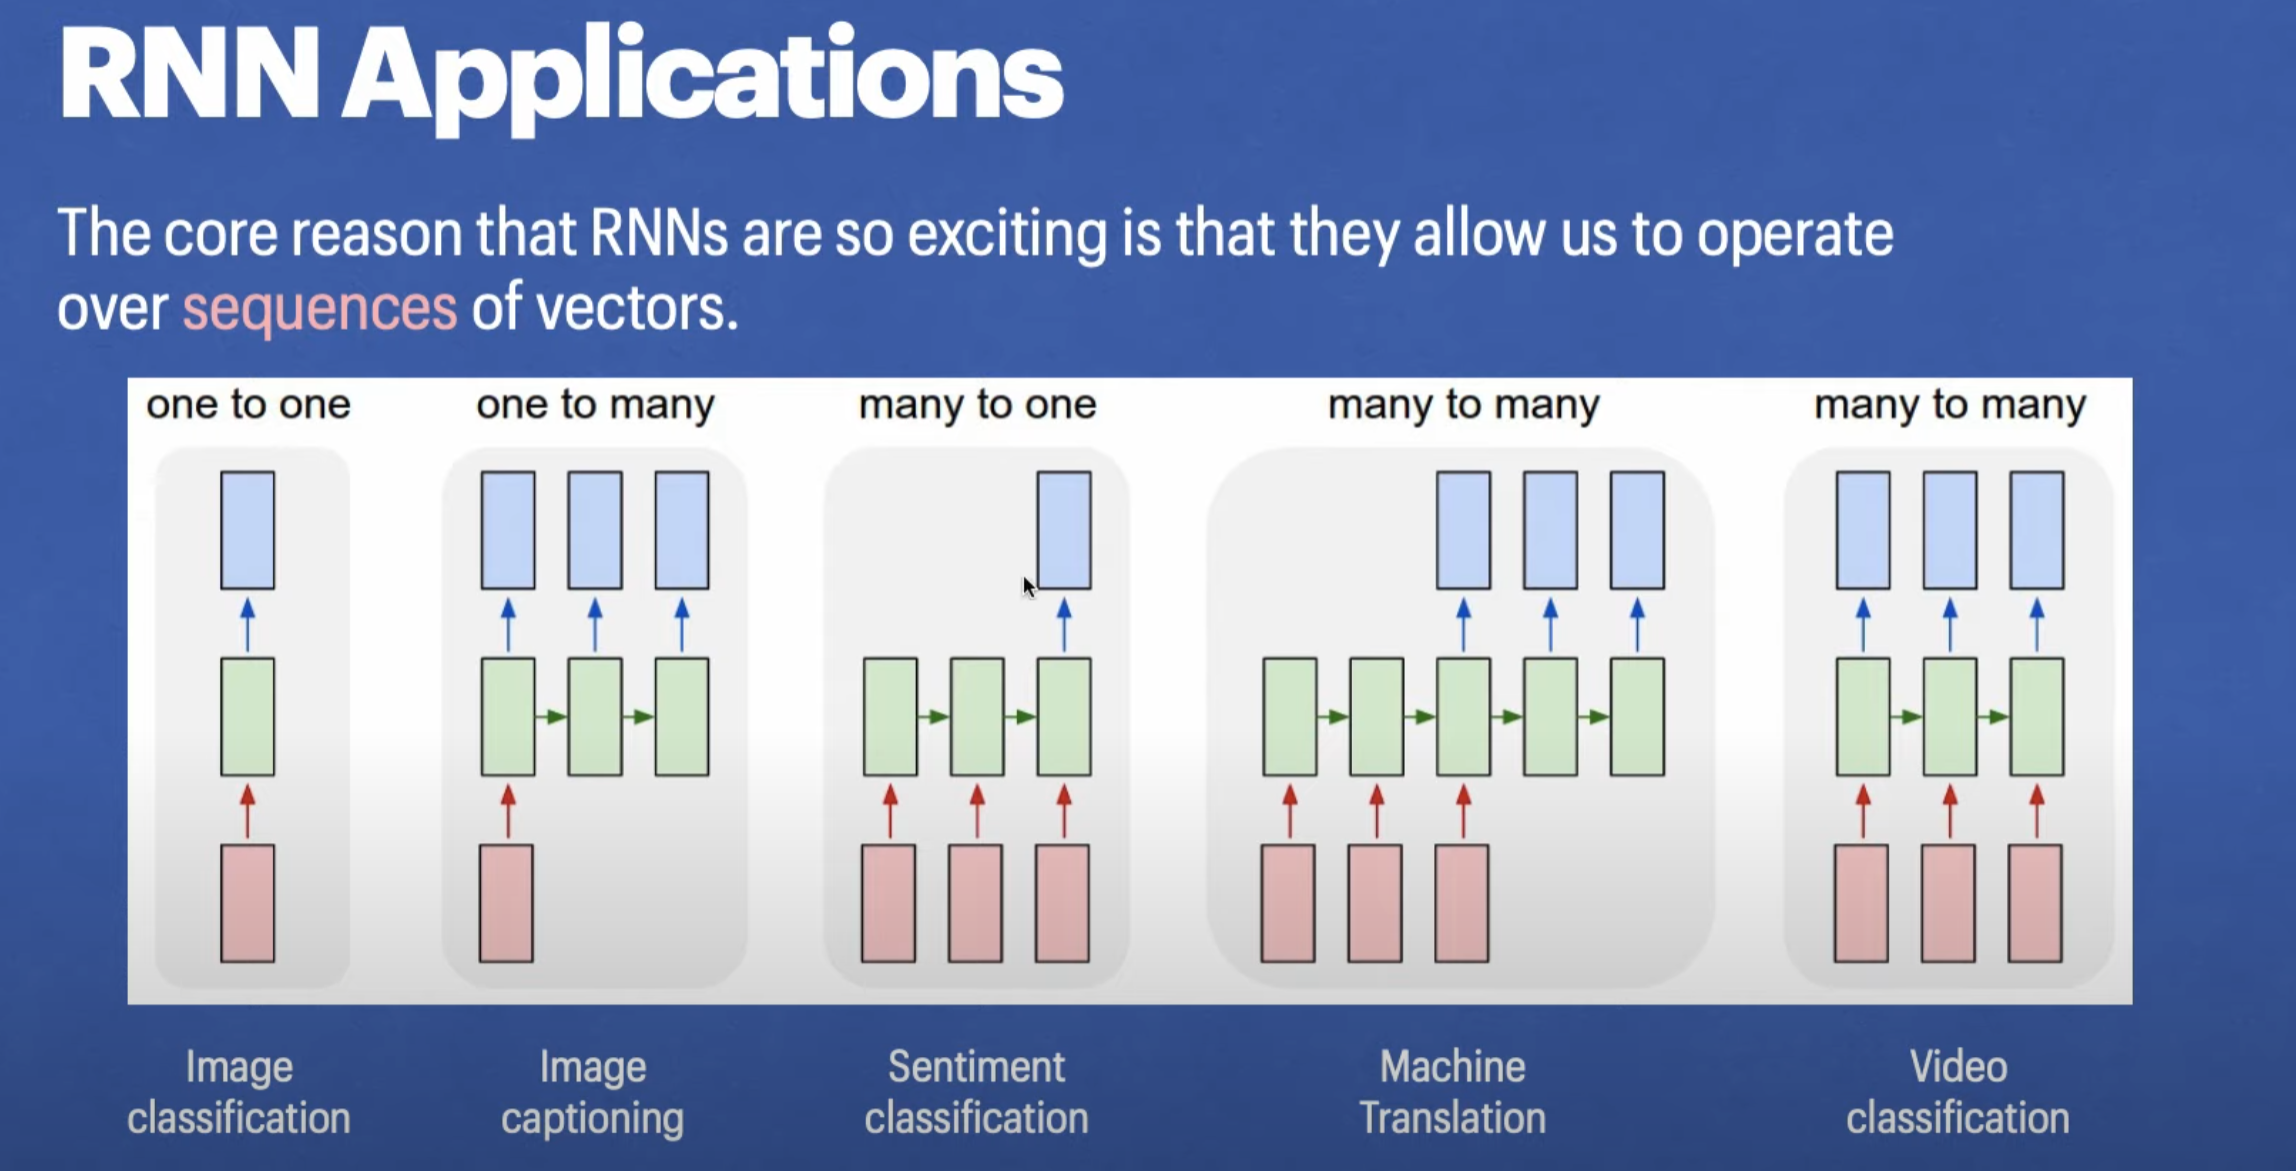

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Hyper-parameters 
hidden_size = 500 
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [7]:
input_size = 28 #Because MNIST dataset contains pics which are 28 pixels
sequence_len = 28
num_layers = 2

In [8]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



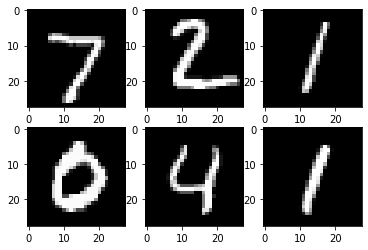

In [9]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [10]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.num_layers=num_layers
    self.hidden_size=hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    #x -> batch_size, sequence_len, input_size
    self.fc = nn.Linear(hidden_size, num_classes)

 
  
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out,_ = self.rnn(x,h0)
    #out: batch_size, seq_length, hidden_size
    #out: (N,28,128)
    out = out[:,-1,:]
    #out: (NN, 128)
    out = self.fc(out)
    return out

In [11]:
model = RNN(input_size, hidden_size,num_layers, num_classes).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [13]:
# Train the model
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 28, 28]
        images = images.reshape(-1, sequence_len, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.9736
Epoch [1/2], Step [200/600], Loss: 0.5923
Epoch [1/2], Step [300/600], Loss: 0.5811
Epoch [1/2], Step [400/600], Loss: 0.6543
Epoch [1/2], Step [500/600], Loss: 0.3087
Epoch [1/2], Step [600/600], Loss: 0.3563
Epoch [2/2], Step [100/600], Loss: 0.3169
Epoch [2/2], Step [200/600], Loss: 0.2229
Epoch [2/2], Step [300/600], Loss: 0.3478
Epoch [2/2], Step [400/600], Loss: 0.5243
Epoch [2/2], Step [500/600], Loss: 0.2860
Epoch [2/2], Step [600/600], Loss: 0.5148


In [14]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_len, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 91.24 %
